In [1]:

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm, time

import glob
import random,time

import math

from functools import partial

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import *
from tensorflow.keras.regularizers import *
import matplotlib.pyplot as plt


**Loading the CIFAR10 dataset**

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

from sklearn.model_selection import train_test_split


x_train, x_val_test, y_train, y_val_test = train_test_split(x_train, y_train, test_size=0.6, random_state=42)


x_test, x_val, y_test, y_val = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)
print(f"Training data samples: {len(x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")


Training data samples: 20000
Validation data samples: 15000
Test data samples: 15000


array([[[245, 238, 246],
        [240, 238, 236],
        [239, 236, 242],
        ...,
        [217, 223, 253],
        [210, 214, 252],
        [206, 209, 251]],

       [[230, 226, 245],
        [228, 226, 242],
        [231, 229, 245],
        ...,
        [201, 203, 232],
        [203, 204, 244],
        [196, 203, 247]],

       [[226, 225, 248],
        [228, 226, 244],
        [234, 232, 246],
        ...,
        [155, 145, 158],
        [190, 189, 223],
        [194, 203, 252]],

       ...,

       [[ 58,  72,  10],
        [ 53,  67,   5],
        [ 72,  90,  11],
        ...,
        [ 51,  65,   8],
        [ 50,  64,   7],
        [ 45,  55,   8]],

       [[ 48,  62,   9],
        [ 53,  66,   9],
        [ 65,  79,   9],
        ...,
        [ 47,  58,   9],
        [ 53,  68,   9],
        [ 49,  64,  11]],

       [[ 45,  59,  12],
        [ 55,  66,  12],
        [ 54,  64,   9],
        ...,
        [ 56,  66,  11],
        [ 51,  67,   8],
        [ 46,  61,   7]]], dtype=uint8)
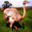

In [9]:
x_train[0]

**Normalization**

In [13]:
new_x_train_nor = x_train/255
x_val_nor  = x_val/255
x_test_nor = x_test/255

**Label preparation**

In [14]:
from keras.src.utils.np_utils import to_categorical
total_class = len(np.unique(y_train))

new_y_train_hot = to_categorical( y_train, total_class)

y_val_hot  = to_categorical( y_val, total_class)

y_test_hot = to_categorical( y_test, total_class)


In [15]:
ijd = 100

print(y_train[ijd], new_y_train_hot[ijd])

[0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:

indx = [i for i in range(0, len(new_x_train_nor))]

random.shuffle(indx)


In [17]:
new_y_train_hot_1 =  []
new_x_train_nor_1 = []

small_f = 5000 # allocated length of the dataset
for i in range(small_f):
  new_x_train_nor_1.append(new_x_train_nor[indx[i]] )
  new_y_train_hot_1.append(new_y_train_hot[indx[i]] )


new_y_train_hot_1 = np.array(new_y_train_hot_1)
new_x_train_nor_1 = np.array(new_x_train_nor_1)

In [18]:
batch_size = 16
auto = tf.data.AUTOTUNE

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(50000)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

train_set =   make_datasets(new_x_train_nor_1, new_y_train_hot_1)
val_set =   make_datasets(x_val_nor, y_val_hot)
test_set =  make_datasets(x_test_nor, y_test_hot )

In [19]:
str_1,str_2 = next(iter(train_set))
stv_1,stv_2 = next(iter(val_set))
sts_1,sts_2 = next(iter(test_set))


print('train, val, test batches', str_1.shape,str_2.shape,stv_1.shape,stv_2.shape,sts_1.shape,sts_2.shape )

train, val, test batches (16, 32, 32, 3) (16, 10) (16, 32, 32, 3) (16, 10) (16, 32, 32, 3) (16, 10)


In [22]:
from keras.regularizers import l2
from keras.layers import BatchNormalization,Activation

filters=32
kernel_size=3
dropout = 0.5
l2_reg = 0.02

inputs = Input(shape=(32, 32, 3))

y = Conv2D(filters=32,kernel_regularizer=l2(l2_reg), kernel_size=kernel_size,activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)


y = Conv2D(filters=64,kernel_regularizer=l2(l2_reg), kernel_size=kernel_size,activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)



y = Conv2D(filters=128,kernel_regularizer=l2(l2_reg), kernel_size=kernel_size,activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)

y = Conv2D(filters=256,kernel_regularizer=l2(l2_reg), kernel_size=kernel_size,activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)

y = Flatten()(y)

y = Dropout(dropout)(y)
outputs = Dense(10, activation='softmax')(y)


model = Model(inputs=inputs, outputs=outputs)



In [23]:

lr_schedule = keras.optimizers.schedules.ExponentialDecay(3e-3, decay_steps=150, decay_rate=0.8)
optima = tf.keras.optimizers.Adam(learning_rate=lr_schedule,clipnorm =1.0)
earlystopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

model.compile(optimizer=optima,loss="categorical_crossentropy", metrics=["accuracy"],)

In [24]:
history = model.fit(train_set,validation_data=val_set,epochs=100,callbacks=[earlystopping])

Epoch 1/100
313/313 [==============================] - 11s 21ms/step - loss: 22.0555 - accuracy: 0.3124 - val_loss: 11.7870 - val_accuracy: 0.2979
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 8.7255 - accuracy: 0.4918 - val_loss: 7.4070 - val_accuracy: 0.4253
Epoch 3/100
313/313 [==============================] - 4s 11ms/step - loss: 5.3801 - accuracy: 0.6264 - val_loss: 6.3690 - val_accuracy: 0.4419
Epoch 4/100
313/313 [==============================] - 4s 11ms/step - loss: 4.0002 - accuracy: 0.7064 - val_loss: 5.4524 - val_accuracy: 0.4831
Epoch 5/100
313/313 [==============================] - 4s 11ms/step - loss: 3.1907 - accuracy: 0.7790 - val_loss: 4.8839 - val_accuracy: 0.5007
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 2.7699 - accuracy: 0.8242 - val_loss: 4.6808 - val_accuracy: 0.5041
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 2.5064 - accuracy: 0.8424 - val_loss: 4.5538 - val_accura

In [25]:
loss_t, acc_t = model.evaluate(test_set)

938/938 [==============================] - 3s 3ms/step - loss: 4.3332 - accuracy: 0.5158


In [26]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


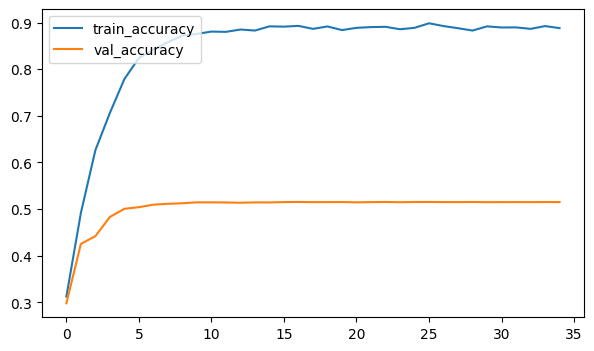

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

In [ ]:


@tf.function
def train_step(x_batch_train, y_batch_train, model ):


    with tf.GradientTape(persistent = True) as tape:
        logits = model(x_batch_train , training=True)
        loss_value = loss_fn(y_batch_train, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip( grads, model.trainable_weights))

    train_acc_metric.update_state(y_batch_train, logits)
    return loss_value